In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np

import src.training as training
import src.models as models

import matplotlib.pyplot as plt

# Set device for PyTorch
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seed for reproducibility
seed = 14
np.random.seed(seed)
torch.manual_seed(seed)

### Load training data

- Emulator must be finetuned using a small sample of spectra - O(100) - from the target N(z)

In [2]:
# Load in data for finetuning the MAML model
filepath = '../cl_ee_mcmc_dndz_nsamples=30000.h5'
n_finetune = 100  # Number of training samples for finetuning

train_data, test_data, ScalerY, ScalerX = training.load_train_test_val(
    filepath=filepath, n_train=n_finetune, n_val=None, n_test=None, seed=seed,
    device=device
)
X_train, y_train = train_data[:]

### Next we need to load the model and apply the trained weights

- Parameters below are as configured for the paper, I haven't done extensive optimisation on them, feel free to play around with them

In [3]:
in_size = X_train.shape[1]
out_size = y_train.shape[1]        

# Construct model architecture
model = models.FastWeightCNN(
    input_size=in_size,
    latent_dim=(16,16),
    output_size=out_size,
    dropout_rate=0.2
)

# Initialise a MetaLearner for training
metalearner = training.MetaLearner(
    model=model,
    outer_lr=0.01, # Training params
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9, # Adam params
    beta2=0.999,
    epsilon=1e-8,
    seed=seed, # Random seed for reproducibility
    device=device
)

# Load an apply the trained meta-weights
weight_path = 'weights\WEIGHTS_5batch_500samples_20tasks_14seed.pt'
metalearner.model.load_state_dict(
    torch.load(weight_path, map_location=device)
)

<All keys matched successfully>

### Now we finetune the model

- Task specific weights are stored separately and passed at runtime so as to protect the meta-weights from being overwritten

In [4]:
finetune_epochs = 64

fast_weights, _ = metalearner.finetune(
    X_train,
    y_train,
    adapt_steps=finetune_epochs,
    use_new_adam=True # Start with fresh adam optimizer state for finetuning
)

### Finally, we can test the trained model on the rest of the sample spectra

In [10]:
print(train_data.tensors[1])

tensor([[-0.3409, -0.3302, -0.3175,  ...,  0.5401,  0.5428,  0.5442],
        [-0.5221, -0.5807, -0.6461,  ..., -2.4361, -2.4526, -2.4681],
        [-1.0944, -1.0651, -1.0305,  ...,  0.9080,  0.9311,  0.9528],
        ...,
        [-1.2848, -1.2862, -1.2869,  ...,  0.1667,  0.1965,  0.2241],
        [-1.0335, -1.0465, -1.0599,  ..., -0.7780, -0.7531, -0.7277],
        [ 0.4306,  0.3640,  0.2894,  ..., -2.4233, -2.4304, -2.4360]])


In [13]:
# Send the test data to a torch dataloader
# Can modify batch size as needed depending on system resources
test_loader = DataLoader(test_data, batch_size=5000, shuffle=False)

# Evaluate the model on the test data
metalearner.model.eval()
y_pred = torch.tensor([]).to(device)
for X_batch, y_batch in test_loader:
    model.eval()
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = metalearner.model(X_batch, params=fast_weights)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)
y_test = test_data.tensors[1]  # Get original test data

# Exponentiate the data
y_pred = torch.exp(y_pred)
y_test = torch.exp(y_test)

test_loss = torch.nn.functional.mse_loss(y_pred, y_test)
print('Test loss:', test_loss.item())

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

Total predictions: torch.Size([29900, 750])
Test loss: 5.0886840202991366e-18


Mean absolute percentage error: 3.3083131
Max absolute percentage error: 36.349976
Fraction of samples with >5% error: 0.20013377926421405


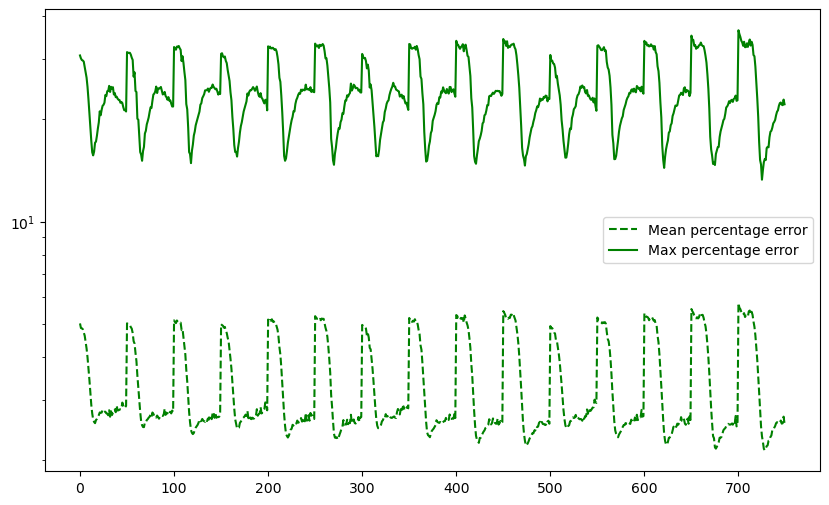

In [19]:
# Plot the results
# Compute mean absolute percentage error along the test set
apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
ell_ape = np.mean(apes, axis=1)
maml_mape = np.mean(apes, axis=0)
maml_xape = np.max(apes, axis=0)
maml_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)

print('Mean absolute percentage error:', np.mean(maml_mape))
print('Max absolute percentage error:', np.max(maml_xape))
print('Fraction of samples with >5% error:', maml_frate)

plt.figure(figsize=(10, 6))
plt.plot(maml_mape, c='g', ls='--', label='Mean percentage error')
plt.plot(maml_xape, c='g', ls='-', label='Max percentage error')
plt.yscale('log')
plt.legend()